In [1]:
import os
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Divide the annotation file into multiple .txt files for each image
# Define the paths
annotation_path = "./grocery_annotations/annotation.txt"
image_dir = "./Images_Grocery/ShelfImages/"

# Open the annotation file
with open(annotation_path, 'r') as f:
    lines = f.readlines()

# Process each line
for line in lines:
    parts = line.split()
    image_name = parts[0]
    num_objects = int(parts[1])
    objects = [parts[i:i+5] for i in range(2, len(parts), 5)]

    # Create a new annotation file for this image
    with open(os.path.join(image_dir, image_name + '.txt'), 'w') as f:
        for obj in objects:
            # Write the object annotation to the file
            f.write(' '.join(obj) + '\n')

In [3]:
from sklearn.model_selection import train_test_split

def list_files(full_data_path = "./Images_Grocery/ShelfImages/", image_ext = '.JPG', test_size = 0.15, validation_size = 0.15):

    files = []

    for r, d, f in os.walk(full_data_path):
        for file in f:
            if file.endswith(image_ext):
                files.append(file)

    # Split the data into training and testing
    train_files, test_files = train_test_split(files, test_size=test_size, random_state=42)

    # Split the training data into training and validation
    train_files, val_files = train_test_split(train_files, test_size=validation_size, random_state=42)

    return train_files, val_files, test_files

In [4]:
training_files, validation_files, test_files = list_files()

print(str(len(training_files)) + " training files")
print(str(len(validation_files)) + " validation files")
print(str(len(test_files)) + " test files")

255 training files
45 validation files
53 test files


In [5]:
input_size = 244
new_size = (244, 244)  # New size (height, width)

def resize_image_and_box(img, box):
    # Calculate the scale factors
    y_scale = input_size / img.shape[0]
    x_scale = input_size / img.shape[1]

    # Resize the image
    resized_img = cv2.resize(img, new_size)

    x, y, w, h = box[0], box[1], box[2], box[3]
    #new_box = [int(x / r), int(y / r), int(w / r), int(h / r)]
    
    # Scale the bounding box coordinates
    resized_box = [int(box[0] * x_scale), int(box[1] * y_scale), int(box[2] * x_scale), int(box[3] * y_scale)]

    return resized_img, resized_box

def format_image(img1, box1):
    img = img1.copy()
    box = box1.copy()
    height, width = img.shape
    max_size = max(height, width)
    r = max_size / input_size
    new_width = int(width / r)
    new_height = int(height / r)
    new_size = (new_width, new_height)
    resized = cv2.resize(img, new_size, interpolation= cv2.INTER_AREA)
    new_image = np.zeros((input_size, input_size), dtype=np.uint8)
    new_image[0:new_height, 0:new_width] = resized

    x, y, w, h = box[0], box[1], box[2], box[3]
    new_box = [int(x / r), int(y / r), int(w / r), int(h / r)]
    
    return new_image, new_box

In [6]:
class CustomDataset(Dataset):
    def __init__(self, images_folder, transform=None):
        self.dataset = self.create_dataset(images_folder)
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        entry = self.dataset[idx]

        # If you want to apply any image transformations
        if self.transform:
            entry["image"] = self.transform(entry["image"])

        # Convert to PyTorch tensor
        image = transforms.ToTensor()(entry["image"])
        #image = image / 255.0
        # Convert bounding boxes and class labels to tensors
        bounding_boxes = torch.tensor(entry["bounding_boxes"], dtype=float)
        class_labels = torch.tensor(entry["class_label"], dtype=torch.int64)
        bounding_boxes = bounding_boxes / torch.tensor([image.shape[2], image.shape[1], image.shape[2], image.shape[1]])
        # Create target dictionary
        target = {
            'boxes': bounding_boxes,
            'labels': class_labels
        }
        return image, target
    
    def create_dataset(self, files, full_data_path = "./Images_Grocery/ShelfImages/"):
        dataset = []
        
        for file in files:
            # Load the image in grayscale
            img = cv2.imread(os.path.join(full_data_path, file), cv2.IMREAD_GRAYSCALE)
            k = 1
            labels = []
            with open(os.path.join(full_data_path, file + ".txt"), 'r') as fp:
                lines = fp.readlines()
                boxes = []
                for line in lines:
                    parts = line.split()
                    box = np.array(parts[:4], dtype=int)
                    xmin = box[0]
                    ymin = box[1]
                    xmax = box[0] + box[2]
                    ymax = box[1] + box[3]
                    box[0] = xmin
                    box[1] = ymin
                    box[2] = xmax
                    box[3] = ymax
                    if(box[0] == 0):
                        box[0] = 0.1
                    copy_img, box = format_image(img, box)
                    #copy_img = copy_img.astype(int) / 255
                    boxes.append(box)
                    labels.append(k)
                    
                dataset.append({
                    "image": copy_img,
                    "bounding_boxes": boxes,
                    "class_label": labels
                })

        return dataset


custom_dataset = CustomDataset(training_files)
validation_dataset = CustomDataset(validation_files)

# Example: Using DataLoader
dataloader = DataLoader(custom_dataset, batch_size=1, shuffle=True, num_workers=0)
validation_dataloader = DataLoader(validation_dataset, batch_size=1, shuffle=True, num_workers=0)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


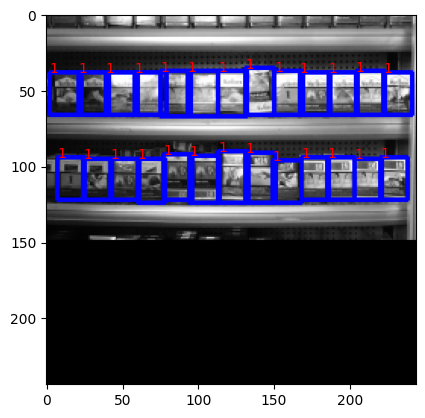

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Get the first batch from the dataloader
first_batch = next(iter(dataloader))

# Get the first image, bounding boxes, and labels from the batch
images = first_batch[0]
targets = first_batch[1]
#class_labels = first_batch['class_label']

# Convert the image tensor to a numpy array and transpose the dimensions for matplotlib
image = images[0].squeeze(0).squeeze(0)
# Convert the image to float32
image = image.numpy().astype(np.float32)

temp_color_img = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
image_height, image_width, _ = temp_color_img.shape

boxes = targets['boxes'][0].numpy()
labels = targets['labels'][0].numpy()

for box, label in zip(boxes, labels):
    norm_xmin, norm_ymin, norm_xmax, norm_ymax = box[0], box[1], box[2], box[3]
    xmin = int(norm_xmin * image_width)
    ymin = int(norm_ymin * image_height)
    xmax = int(norm_xmax * image_width)
    ymax = int(norm_ymax * image_height)

    #cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 0, 255), 2)
    cv2.rectangle(temp_color_img, (xmin, ymin), (xmax, ymax), (0, 0, 255), 2)
    plt.text(xmin, ymin, str(label), color='red')
plt.imshow(temp_color_img)

In [8]:
# import torch.nn as nn
# import torch.nn.functional as F

# class PredictionNet(nn.Module):
#     def __init__(self, num_classes) -> None:
#         super(PredictionNet, self).__init__()
#         num_boxes = {"conv4_3": 4, "conv7": 6, "conv8_2": 6,
#                      "conv9_2": 6, "conv10_2": 4, "conv11_2": 4}

#         self.loc_layers = nn.ModuleList()
#         self.cls_layers = nn.ModuleList()
#         self.num_classes = num_classes
#         in_channels = {"conv4_3": 512, "conv7":512 , "conv8_2": 512, "conv9_2": 256, "conv10_2": 256, "conv11_2": 256}
        
#         for feature_map in ["conv4_3", "conv7", "conv8_2", "conv9_2", "conv10_2", "conv11_2"]:
#             loc_layer = nn.Conv2d(in_channels[feature_map], num_boxes[feature_map] * 4, kernel_size=(3, 3), padding=1)
#             cls_layer = nn.Conv2d(in_channels[feature_map], num_boxes[feature_map] * num_classes, kernel_size=(3, 3), padding=1)

#             self.loc_layers.append(loc_layer)
#             self.cls_layers.append(cls_layer)
#         self.weights_init()

#     def forward(self, out_vgg, out_conv7, out_conv8, out_conv9, out_conv10, out_conv11):
#         # Location predictions
#         locs_pred = []
#         for i, conv_out in enumerate([out_vgg, out_conv7, out_conv8, out_conv9, out_conv10, out_conv11]):
#             locs_pred.append(self.loc_layers[i](conv_out).permute(0, 2, 3, 1).contiguous().view(conv_out.size(0), -1, 4))
        
#         locs_pred = torch.cat(locs_pred, dim=1)

#         # Class predictions
#         cls_pred = []
#         for i, conv_out in enumerate([out_vgg, out_conv7, out_conv8, out_conv9, out_conv10, out_conv11]):
#             cls_pred.append(self.cls_layers[i](conv_out).permute(0, 2, 3, 1).contiguous().view(conv_out.size(0), -1, self.num_classes))
        
#         cls_pred = torch.cat(cls_pred, dim=1)

#         return locs_pred, cls_pred

    
#     def weights_init(self):
#         for loc_layer, cls_layer in zip(self.loc_layers, self.cls_layers):
#             nn.init.xavier_uniform_(loc_layer.weight)
#             nn.init.zeros_(loc_layer.bias)
#             nn.init.xavier_uniform_(cls_layer.weight)
#             nn.init.zeros_(cls_layer.bias)


In [9]:

# class ConvNet (nn.Module):
#     def __init__(self ) -> None:
#         super(ConvNet,self).__init__()
#         self.conv8_1 = nn.Conv2d(512, 256, kernel_size=(1, 1), padding= 0)
#         self.conv8_2 = nn.Conv2d(256, 512, kernel_size= (3, 3), padding= 1, stride= 2)
        
#         self.conv9_1 = nn.Conv2d(512, 128, kernel_size= (1, 1), padding= 0)
#         self.conv9_2 = nn.Conv2d(128, 256, kernel_size= (3, 3), padding= 1, stride= 2)
        
#         self.conv10_1 = nn.Conv2d(256, 128, kernel_size= (1, 1), padding= 0)
#         self.conv10_2 = nn.Conv2d(128, 256, kernel_size= (3, 3), padding= 0)
        
#         self.conv11_1 = nn.Conv2d(256, 128, kernel_size= (1, 1), padding= 0)
#         self.conv11_2 = nn.Conv2d(128, 256, kernel_size= (3, 3), padding= 0) 
#     def forward(self, conv7_out):
       
#         x = conv7_out    #(N, 512, 19, 19)
#         x = F.relu(self.conv8_1(x))    #(N, 256, 19, 19)
#         x = F.relu(self.conv8_2(x))    #(N, 512, 10, 10)
#         conv8_2_out = x
        
#         x = F.relu(self.conv9_1(x))    #(N, 128, 10, 10)
#         x = F.relu(self.conv9_2(x))    #(N, 256, 5, 5)
#         conv9_2_out = x
        
#         x = F.relu(self.conv10_1(x))   #(N, 128, 5, 5)
#         x = F.relu(self.conv10_2(x))   #(N, 256, 3, 3)
#         conv10_2_out = x
        
#         x = F.relu(self.conv11_1(x))   #(N, 128, 3, 3)
#         conv11_2_out = F.relu(self.conv11_2(x))   #(N, 256, 1, 1)

#         return conv8_2_out, conv9_2_out, conv10_2_out, conv11_2_out

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiBoxLoss(nn.Module):
    def __init__(self, default_boxes, threshold=0.5, neg_pos=3, alpha=1):
        super(MultiBoxLoss, self).__init__()
        self.default_boxes=default_boxes
        self.threshold = threshold
        self.neg_pos = neg_pos
        self.alpha = alpha
        self.smooth_l1 = nn.SmoothL1Loss()
        self.cross_entropy = nn.CrossEntropyLoss(reduction='sum')

    def forward(self, locs_pred, cls_pred, boxes, labels):
        batch_size = locs_pred.size(0)
        n_default_boxes = self.default_boxes.size(0)
        num_classes = cls_pred.size(2)


        # Initialize tensors for target values
        true_locs = torch.zeros((batch_size, n_default_boxes, 4), dtype=torch.float).to(locs_pred.device)
        true_classes = torch.zeros((batch_size, n_default_boxes), dtype=torch.long).to(locs_pred.device)

        # Target assignment
        for i in range(batch_size):
            n_objects = boxes[i].size(0)

            overlap = self.IoU(boxes[i], self.default_boxes)

            overlap_for_each_prior, object_for_each_prior = overlap.max(dim=0)

            _, prior_for_each_object = overlap.max(dim=1)
            object_for_each_prior[prior_for_each_object] = torch.LongTensor(range(n_objects)).to(locs_pred.device)
            overlap_for_each_prior[prior_for_each_object] = 1.

            label_for_each_prior = labels[i][object_for_each_prior]
            label_for_each_prior[overlap_for_each_prior < self.threshold] = 0

            true_classes[i] = label_for_each_prior
            true_locs[i] = boxes[i][object_for_each_prior], self.default_boxes


        # Compute localization loss
        pos = true_classes > 0
        loc_loss = F.smooth_l1_loss(locs_pred[pos], true_locs[pos])

        # Compute confidence loss
        conf_loss = F.cross_entropy(cls_pred.view(-1, num_classes), true_classes.view(-1), ignore_index=-1)

        return loc_loss, conf_loss

    def IoU(self, box_a, box_b):
        inter = self.intersect(box_a, box_b)
        area_a = (box_a[:, 2] - box_a[:, 0]) * (box_a[:, 3] - box_a[:, 1])
        area_b = (box_b[:, 2] - box_b[:, 0]) * (box_b[:, 3] - box_b[:, 1])
        print("Size of area_a.unsqueeze(1):", area_a.unsqueeze(1).size())
        print("Size of area_b.unsqueeze(0):", area_b.unsqueeze(0).size())
        print("Size of inter:", inter.size())
        union = area_a.unsqueeze(1) + area_b.unsqueeze(0) - inter
      
        return inter / union

    def intersect(self, box_a, box_b):
        max_xy = torch.min(box_a[:, 2:].unsqueeze(1), box_b[:, 2:].unsqueeze(0))
        min_xy = torch.max(box_a[:, :2].unsqueeze(1), box_b[:, :2].unsqueeze(0))
        inter = torch.clamp((max_xy - min_xy), min=0)
        return inter


In [11]:
# import torchvision.models as models

# import torch
# class ModifiedVGG16(nn.Module):
#     def __init__(self, num_classes, pretrained=True):
#         super(ModifiedVGG16, self).__init__()
        
#         # Ladda ner hela VGG-16-modellen
#         vgg16 = models.vgg16(pretrained=pretrained)
#         print(vgg16)
#         # Hämta lager från VGG-16
#         self.features = vgg16.features

#         self.features[0] = nn.Conv2d(1, 64, kernel_size=3, padding=1)
#         # Lägg till nya lager efter VGG-16
#         self.conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6)
#         self.conv7 = nn.Conv2d(1024, 512, kernel_size=1)
        
#         # Byt ut sista fully connected layer för din specifika uppgift
#         vgg16.classifier[6] = nn.Linear(4096, 1024)
        
#         # Kopiera över de modifierade lagren till din modell
#         self.load_state_dict(vgg16.state_dict(), strict=False)
#            # Lägg till AuxiliaryNet och PredictionNet
#         self.auxiliary_net = ConvNet()
#         self.prediction_net = PredictionNet(num_classes=num_classes)

#         # Lägg till default_boxes som en attribut
#         default_boxes=self.create_default_boxes(num_channels=1)
#         # Skapa en instans av MultiBoxLoss med default_boxes
#         self.multibox_loss = MultiBoxLoss(default_boxes=default_boxes)

#     def forward(self, image):
#         x = self.features(image)
#         vgg=x 
       
#         x = F.interpolate(x, size=(19, 19), mode='bilinear', align_corners=False)
#         x = F.relu(self.conv6(x))
#         x =F.relu( self.conv7(x))
#         conv7=x
#          # Lägg till anrop för ConvNet
#         aux_out = self.auxiliary_net(conv7)
#         print(len(aux_out))
#         locs_pred, cls_pred = self.prediction_net.forward(vgg, conv7, aux_out[0], aux_out[1], aux_out[2], aux_out[3])
#         print("Size of locs_pred:", locs_pred.size())
#         print("Size of cls_pred:", cls_pred.size())
#         # Beräkna förlusten med MultiBoxLoss
#         loss = self.multibox_loss(locs_pred, cls_pred, targets['boxes'], targets['labels'])

#         return loss, aux_out, locs_pred, cls_pred
    
    

In [12]:
# # Skapa en instans av din modifierade VGG-16-modell
# num_classes = 2  # Ersätt med det faktiska antalet klasser i din uppgift
# ssd_model= ModifiedVGG16(num_classes=num_classes, pretrained=True)

In [13]:
import math
def create_default_boxes():
    fmap_wh = {"vgg": 38, "conv7": 19, "conv8": 10, "conv9": 5,
            "conv10": 3, "conv11": 1}

    scales = {"vgg": 0.1, "conv7": 0.2, "conv8": 0.375,
        "conv9": 0.55, "conv10": 0.725, "conv11": 0.9}

    aspect_ratios = {"vgg": [1., 2.], "conv7": [1., 2., 0.5],
                "conv8": [1., 2., 0.5], "conv9": [1., 2., 0.5],
                "conv10": [1., 2.], "conv11": [1., 2.]}

    fmaps = list(fmap_wh.keys())

    default_boxes = []
    for k, fmap in enumerate(fmaps):
        for i in range(fmap_wh[fmap]):
            for j in range(fmap_wh[fmap]):
                cx = (j + 0.5) / fmap_wh[fmap]
                cy = (i + 0.5) / fmap_wh[fmap]

                for ratio in aspect_ratios[fmap]:
                    default_boxes.append([cx, cy, scales[fmap] * math.sqrt(ratio),
                                        scales[fmap] / math.sqrt(ratio)])  # (cx, cy, w, h)

                    if ratio == 1:
                        try:
                            add_scale = math.sqrt(scales[fmap] * scales[fmaps[k + 1]])
                        except IndexError:
                            # for the last feature map
                            add_scale = 1.
                        default_boxes.append([cx, cy, add_scale, add_scale])

    default_boxes = torch.FloatTensor(default_boxes).to(torch.device("cuda" if torch.cuda.is_available() else "cpu")) # (8732, 4)
    default_boxes.clamp_(0, 1)
    return default_boxes


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch import device
from torchvision.models.detection import ssd300_vgg16 # Choose an SSD model from torchvision


# Create SSD model
ssd_model = ssd300_vgg16(pretrained=True)  # You can use a different SSD model
#print(ssd_model)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ssd_model = ssd_model.to(device)


# Skapa en instans av din MultiBoxLoss
default_boxes = create_default_boxes()  # Du måste fylla i default_boxes baserat på SSD-modellen du använder
multi_box_loss = MultiBoxLoss(default_boxes)
multi_box_loss = multi_box_loss.to(device)  # Flytta loss-funktionen till önskad enhet

# Optimizer
optimizer = optim.SGD(ssd_model.parameters(), lr=0.001, momentum=0.9)
num_epochs=10
# Träning
for epoch in range(num_epochs):
    for inputs, targets in dataloader:
        inputs = inputs.to(device)
        #print('input: ',inputs.shape)
        #print('Box:', targets['boxes'])
        
        ls = []
        # Move each tensor in the 'targets' dictionary to the device
        targets = {key: value.squeeze(0).to(device) for key, value in targets.items()}
        ls.append(targets)
        #print(targets)
        
        #ls = []
        # Move each tensor in the 'targets' dictionary to the device
        #targets = {key: value.to(device) for key, value in targets.items()}
        #ls.append(targets)

        #for i, value in enumerate(ls):
        #    print(f'Index: {i}, Value: {value}')
        
        optimizer.zero_grad()

        
        output = ssd_model(inputs, [targets])

        # The output is a dictionary containing the losses
        loss_dict = output

        # Calculate the total loss
        total_loss = sum(loss for loss in loss_dict.values())

        # Backward pass and optimization
        total_loss.backward()
        optimizer.step()
        
        
        
        # output = ssd_model(inputs, ls)
   
        
        # locs_pred = output['bbox_regression']
        # cls_pred = output['classification']
        # print(locs_pred.shape)
        # print(cls_pred.shape)
        # # Forward pass
        # #locs_pred, cls_pred = ssd_model(inputs, ls)
        # #print(type(locs_pred), type(cls_pred))
        # # Calculate loss with MultiBoxLoss
        # loc_loss, conf_loss = multi_box_loss(locs_pred, cls_pred, boxes=targets['boxes'], labels=targets['labels'])

        # # Total loss
        # total_loss = loc_loss + conf_loss

        # # Backward pass and optimization
        # total_loss.backward()
        # optimizer.step()



c:\Users\calim\anaconda3\envs\rl\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\calim\anaconda3\envs\rl\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SSD300_VGG16_Weights.COCO_V1`. You can also use `weights=SSD300_VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


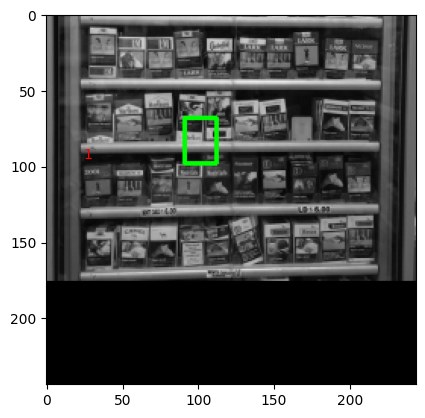

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


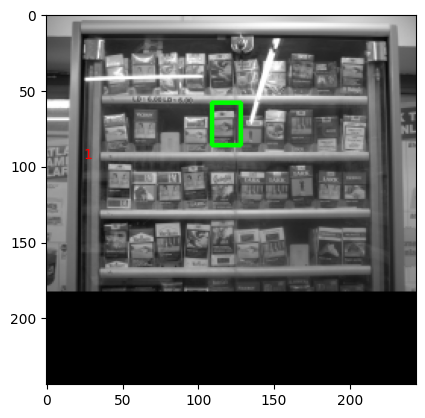

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


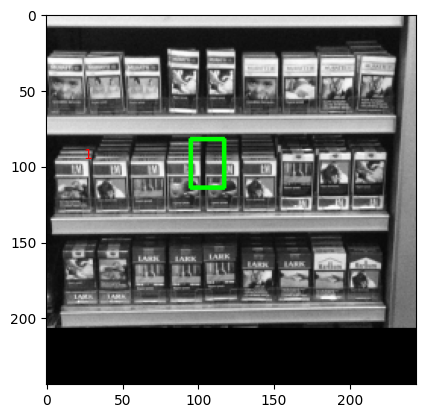

In [18]:
# Put the model in evaluation mode
ssd_model.eval()

# Loop over the test dataset
for idx, (images, targets) in enumerate(validation_dataloader):
    # Move the images and targets to the device
    images = list(image.to(device) for image in images)
    targets = [{k: v.squeeze(0).to(device) for k, v in targets.items()}]

    # Make predictions
    with torch.no_grad():
        predictions = ssd_model(images)

    # Draw the predicted boxes
    for i, image in enumerate(images):
        # Convert the image tensor to a numpy array and transpose the dimensions for matplotlib
        #image_np = image.permute(1, 2, 0).cpu().numpy()
        image_copy = image.squeeze(0)
        image_copy = image_copy.cpu().numpy().astype(np.float32)
        temp_color_img = cv2.cvtColor(image_copy, cv2.COLOR_GRAY2RGB)
        # Get the predicted boxes and labels
        pred_boxes = predictions[i]['boxes'].cpu().numpy()
        pred_labels = predictions[i]['labels'].cpu().numpy()
        target_boxes = targets[i]['boxes'].cpu().numpy()
        target_labels = targets[i]['labels'].cpu().numpy()

        # Draw the boxes
        # for target_box, target_label in zip(target_boxes, target_labels):
        #     norm_xmin, norm_ymin, norm_xmax, norm_ymax = target_box[0], target_box[1], target_box[2], target_box[3]
        
        #     xmin = int(norm_xmin * image_width)
        #     ymin = int(norm_ymin * image_height)
        #     xmax = int(norm_xmax * image_width)
        #     ymax = int(norm_ymax * image_height)
        #     cv2.rectangle(temp_color_img, (xmin, ymin), (xmax, ymax), (0, 0, 255), 2)
        #     plt.text(xmin, ymin, str(label), color='blue')

        for pred_box, pred_label in zip(pred_boxes, pred_labels):
            pred_xmin, pred_ymin, pred_xmax, pred_ymax = pred_box[0], pred_box[1], pred_box[2], pred_box[3]
            
            pred_xmin = int(pred_xmin * image_width)
            pred_ymin = int(pred_ymin * image_height)
            pred_xmax = int(pred_xmax * image_width)
            pred_ymax = int(pred_ymax * image_height)
            cv2.rectangle(temp_color_img, (pred_xmin, pred_ymin), (pred_xmax, pred_ymax), (0, 255, 0), 2)
            plt.text(pred_xmin, pred_ymin, str(label), color='red')
        # Show the image
        plt.imshow(temp_color_img)
        plt.show()

In [16]:
# from torch import device
# from torch.optim import Adam
# # Optimizer
# optimizer = Adam(ssd_model.parameters(), lr=0.001)

# # Loss function
# multibox_loss = MultiBoxLoss(default_boxes=ssd_model.create_default_boxes(1))
# # Träningsloopen
# num_epochs = 10

# for epoch in range(num_epochs):
#     ssd_model.train()

#     for batch_idx, (images, targets) in enumerate(dataloader):
#         optimizer.zero_grad()

#         # Ladda data till enheten
#         device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#         images = images.to(device)
#         print(images.shape)
        
#         targets['boxes'] = targets['boxes'].to(device)
#         targets['labels'] = targets['labels'].to(device)

#         # Gör förutsägelser
#         loss, _, locs_pred, cls_pred = ssd_model(images)

#         # Beräkna förlusten och uppdatera vikterna
#         loss.backward()
#         optimizer.step()

#         # Skriv ut framsteg
#         if batch_idx % 10 == 0:
#             print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}/{len(dataloader)}, Loss: {loss.item()}')

# # Sparar modellen efter träning
# torch.save(ssd_model.state_dict(), 'ssd_model.pth')


In [17]:
# import torch
# import torchvision.transforms as transforms
# from torch.utils.data import DataLoader

# # Skapa en enkel datasetklass för teständamål
# class TestDataset(torch.utils.data.Dataset):
#     def __init__(self, num_samples=100, input_size=(3, 244, 244)):
#         self.num_samples = num_samples
#         self.input_size = input_size
#         self.transform = transforms.Compose([transforms.ToTensor()])

#     def __len__(self):
#         return self.num_samples

#     def __getitem__(self, idx):
#         # Skapa en slumpmässig bild med rätt indatastorlek (3, 300, 300)
#         sample = torch.rand(self.input_size)
#         return sample

# # Skapa testdataset och dataloaderA
# test_dataset = TestDataset()
# test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# # Flytta modellen till önskad enhet (CPU eller GPU)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# ssd_model.to(device)

# # Testa modellen
# ssd_model.eval()
# for batch_idx, inputs in enumerate(test_loader):
#     inputs = inputs.to(device)
#     print(inputs.shape)  # Lägg till denna rad för att skriva ut storleken på dina inputs
#     outputs = ssd_model(inputs)

#     # Anta att cls_pred är ditt output för klassprediktionen
#     cls_pred = outputs[-1]

#     # Du kan utföra ytterligare utvärderingar eller inspektioner här baserat på ditt behov
#     print(f"Batch {batch_idx}, Output Shape: {cls_pred.shape}")

# # Kom ihåg att återgå modellen till träningsläge om den behöver träna igen
# ssd_model.train()


# # # Flytta modellen till önskad enhet (CPU eller GPU)
# # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# # ssd_model.to(device)

# # # Välj en optimeringsalgoritm och inställningar
# # optimizer = optim.Adam(ssd_model.parameters(), lr=0.001)

# # # Loop för träningssteg
# # for epoch in range(num_epochs):
# #     for batch_idx, (inputs, targets) in enumerate(train_loader):
# #         # Nollställ gradienter
# #         optimizer.zero_grad()

# #         # Gör förutsägelser och beräkna förlust
# #         outputs = ssd_model(inputs)
# #         loss = calculate_multibox_loss(outputs, targets)  # Implementera eller använd en befintlig funktion för att beräkna förlusten

# #         # Backpropagation och optimering
# #         loss.backward()
# #         optimizer.step()

# #         # Utvärdera och/eller skriv ut resultaten efter varje träningssteg
